In [1]:
import ee
import collections
collections.Callable = collections.abc.Callable
import geemap
from geemap import chart

%matplotlib inline
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWgz3zfWg-_VOs9SSY8AjBnACQ4JKMp57NB8Bv6U32n7EBZ-t5yfWBM



Successfully saved authorization token.


<h3> Imports </h3>

In [16]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR")
gsw = ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
s1 = ee.ImageCollection('COPERNICUS/S1_GRD')
ls8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
focus = ee.Geometry.Polygon(
        [[[27.350233348102517, -7.518171474050515],
          [27.350233348102517, -7.57841301205225],
          [27.436407359332986, -7.57841301205225],
          [27.436407359332986, -7.518171474050515]]])
WestMine = ee.Geometry.Polygon(
        [[[27.358738291876765, -7.561662590595413],
          [27.36234318079278, -7.564044944105011],
          [27.370411265509578, -7.545155923172768],
          [27.363201487677546, -7.53885939945966],
          [27.35564838709161, -7.542262937167664]]])
EastMine = ee.Geometry.Polygon(
        [[[27.40010868372247, -7.521416293051669],
          [27.400966990607234, -7.534520294117901],
          [27.381225932257625, -7.552729091874256],
          [27.384659159796687, -7.55426063803815],
          [27.40457187952325, -7.542008116801026],
          [27.406975138800593, -7.53877475471045],
          [27.40285526575372, -7.521586477421349]]])
TailingPond = ee.Geometry.MultiPolygon(
        [[[[27.40117714611331, -7.528029420400128],
           [27.40143463817874, -7.529901416251066],
           [27.40237877575198, -7.5338155632667805],
           [27.404009558833035, -7.535347176386731],
           [27.403837897456082, -7.531603223645428],
           [27.402807929194363, -7.53075232078353],
           [27.402464606440457, -7.527518874674277]]],
         [[[27.401692130244168, -7.537219140622778],
           [27.40160629955569, -7.538835830496198],
           [27.402207114375027, -7.539516540215821],
           [27.40564034191409, -7.539091096766489],
           [27.40564034191409, -7.538410386377943]]],
         [[[27.38813088146487, -7.548791103460967],
           [27.38890335766116, -7.549046363857512],
           [27.391821601069363, -7.5484507560311345],
           [27.389761664545926, -7.546749014863657]]]])
MinePile = ee.Geometry.MultiPolygon(
        [[[[27.39990282562306, -7.538976580191123],
           [27.39863682296803, -7.539487112415201],
           [27.398057465820813, -7.54067835192985],
           [27.397799973755383, -7.542380116977695],
           [27.398883584767866, -7.542497115405488],
           [27.4003963520818, -7.542784285193142],
           [27.401705270081067, -7.541890860211821],
           [27.4014048626714, -7.540295453871944],
           [27.400782588904605, -7.539561565404619]]],
         [[[27.40360114464233, -7.528471399345152],
           [27.40287158379028, -7.53102411635294],
           [27.40506026634643, -7.531151751808675],
           [27.40561816582153, -7.528769217103983]]],
         [[[27.400167917103268, -7.535108432289119],
           [27.400554155201412, -7.5369803975571035],
           [27.403300737232662, -7.537108031257986],
           [27.403944467396236, -7.5352360665416755],
           [27.402013276905514, -7.533491728501599]]],
         [[[27.357092737193568, -7.547347692672706],
           [27.357650636668666, -7.550155558119731],
           [27.359431623454554, -7.550389546083809],
           [27.360375761027797, -7.547985845511823],
           [27.35890590547972, -7.545039700922603],
           [27.357500432963832, -7.545135422206587]]]]);
mines = ee.FeatureCollection("users/rishiAgarwal/Congo_Active_Mines")

<h3> Visualizations </h3>

In [79]:
rgbVis = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
}


vigsVis = {
    'min': 0,
    'max': 2.5,
    'palette': ['white', 'green']
}

ndviVis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']
}

ironVis = {
    'min': 0,
    'max': 0.25,
    'palette': ['white', 'gray']
}

clayVis = {
    'min': 0,
    'max': 0.25,
    'palette': ['white', 'brown']
}

ndmiVis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'blue']
}

bsiVis = {
    'min': -0.11390094234742729, 
    'max': 0.12724605991882074, 
    'palette': ['white', '#7a5230']
}
ndbiVis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red']
}
greenNIRVis = {
    'min': 0,
    'max': 0.5,
    'palette': ['white', 'green']
}

<h3> True Color Composites </h3>

In [19]:
def create_median_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = s2 \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

def add_median_composites(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
        
    return Map

In [20]:
images = create_median_composites(focus, 2019, 2021)
Map = add_median_composites(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> NDVI </h3>

In [33]:
def create_ndvi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        ndvi = image.normalizedDifference(['B8', 'B4'])
        Map.addLayer(ndvi, ndviVis, 'NDVI ' + str(year))
        
    return Map


In [82]:
Map = create_ndvi_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> NDMI </h3>

In [35]:
def create_ndmi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        ndmi = image.normalizedDifference(['B8', 'B11'])
        Map.addLayer(ndmi, ndmiVis, 'NDMI ' + str(year))
        
    return Map


In [36]:
Map = create_ndmi_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> GreenNIR </h3>

In [112]:
def create_nir_g_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        nirG = image.normalizedDifference(['B8', 'B3'])
        Map.addLayer(nirG, greenNIRVis, 'NIR/G ' + str(year))
        
    return Map


In [113]:
Map = create_nir_g_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> HCSI </h3>

In [108]:
#HCSI = (B07 − B05)/B04 × (B04/B03)
def create_hcsi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        hcsi = image.expression(
            '((X - Y) / A) * (A / B)', {
                'X': image.select('B7'),
                'Y': image.select('B5'),
                'A': image.select('B4'),
                'B': image.select('B3')
            })
            
        Map.addLayer(hcsi, {
            'min': 0,
            'max': 1.5,
            'palette': ['white', 'red']
        }, 'HSCI ' + str(year))
        
    return Map

In [109]:
Map = create_hcsi_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

In [105]:
def extract_data(image):
    stats = image.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': image.geometry(),
        'scale': 100
    })
    
    properties = {
        'Year': image.get('system:index'),
        'hcsi': stats.get('hcsi'),
    }
    
    return ee.Feature(None, properties)

def add_all_bands(image):
    hcsi = image.expression(
            '((X - Y) / A) * (A / B)', {
                'X': image.select('B7'),
                'Y': image.select('B5'),
                'A': image.select('B4'),
                'B': image.select('B3')
            }).rename('hcsi')
    
    return image.addBands([hcsi])

def plotGraph(geometry, title):
    images1 = ee.ImageCollection(create_median_composites(geometry, 2019, 2021))
    with_bands1 = images1.map(add_all_bands)
    data1 = ee.FeatureCollection(with_bands1.map(extract_data))
    df1 = geemap.ee_to_pandas(data1)
    images1 = create_median_composites(geometry, 2019, 2021)
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(9,9)

    xticks = [t[1] for t in images1]
    ax.set_xticks([0, 1, 2], xticks)
    df1.plot(ax=ax,
             title = title,
             xlabel='Year',
             ylabel='Mean Band Value',
             marker='o')
    plt.show()

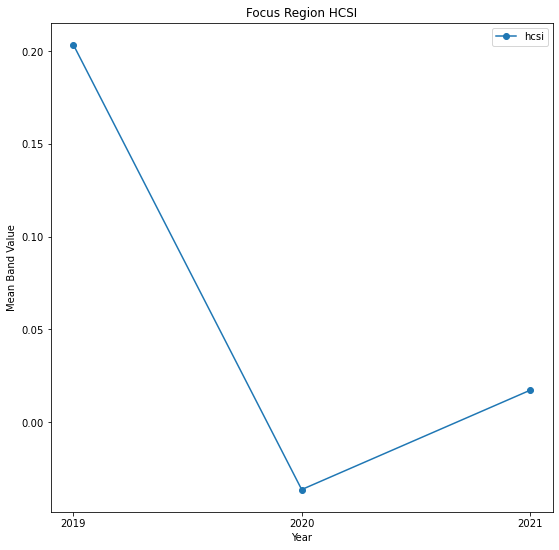

In [114]:
plotGraph(TailingPond, 'Focus Region HCSI')

<h3> VH Band </h3>

In [102]:
def create_vh_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = s1 \
            .filter(ee.Filter.eq('instrumentMode','IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
            .filter(ee.Filter.eq('resolution_meters',10)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
            .select('VH')

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

def add_vh_composites(images, imagesVH, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
    
    for image, year in imagesVH:
        Map.addLayer(image, {'min':-25, 'max':0}, str(year) + ' VH Composite')
        
    return Map

In [115]:
imagesS1vh = create_vh_composites(focus, 2019, 2021)
Map = add_vh_composites(images, imagesS1vh, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> VH Calculations </h3>

In [55]:
cpThreshold = 8
permanentWater = gsw.select('seasonality').gte(7).clip(focus)

In [92]:
def create_vh_calcs(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)

    for image, year in images:

        filtered = s2 \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
        .filter(ee.Filter.intersects('.geo', geometry)) \
        .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \

        composite = filtered.median().clip(geometry)

        Map.addLayer(composite, rgbVis, str(year) + ' Median Composite')

        ndvi = composite.normalizedDifference(['B8', 'B4'])
        nirG = composite.normalizedDifference(['B8', 'B3'])
        ndmi = composite.normalizedDifference(['B8', 'B11'])

        waterStorage = image.lt(-22).rename('water').And(nirG.lt(0.1).Or(ndmi.gt(.3))).selfMask()
        connectW = waterStorage.connectedPixelCount(25)
        waterStorage = waterStorage.updateMask(connectW.gt(cpThreshold))
        Map.addLayer(waterStorage, {'min':0, 'max':1, 'palette': ['blue']}, 'Water ' + str(year))

        mining = image.gte(-22).And(image.lt(-18)).And(ndvi.lt(.15)).rename('mine').selfMask()
        mining = mining.where(permanentWater,0).selfMask()
        connectM = mining.connectedPixelCount(25)
        mining = mining.updateMask(connectM.gt(cpThreshold))
        Map.addLayer(mining, {'min':0, 'max':1, 'palette': ['red']}, 'Mining Estimate ' + str(year))

    return Map

In [93]:
Map = create_vh_calcs(imagesS1vh, focus)
legend_dict = {
    'Water': ('0000FF'), # blue
    'Mine Estimate': ('FF0000'), # red
}
Map.add_legend(legend_title='Legend', legend_dict=legend_dict, position='bottomright')
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> VV Band </h3>

In [116]:
def create_vv_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = s1 \
            .filter(ee.Filter.eq('instrumentMode','IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
            .filter(ee.Filter.eq('resolution_meters',10)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
            .select('VV')

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

def add_vv_composites(images, imagesVV, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
    
    for image, year in imagesVV:
        Map.addLayer(image, {'min':-25, 'max':0}, str(year) + ' VV Composite')
        
    return Map

In [117]:
imagesS1vv = create_vv_composites(focus, 2019, 2021)
Map = add_vv_composites(images, imagesS1vv, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> VH/VV Band Ratio </h3>

In [70]:
def create_vv_vh_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = s1 \
            .filter(ee.Filter.eq('instrumentMode','IW')) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
            .filter(ee.Filter.eq('resolution_meters',10)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
            .select(['VV', 'VH'])

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

def add_vv_vh_composites(images, imagesRatio, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
    
    for image, year in imagesRatio:
        Map.addLayer(image.select('VV').divide(image.select('VH')), {}, str(year) + ' VV/VH')
        
    return Map

In [118]:
imagesS1ratio = create_vv_vh_composites(focus, 2019, 2021)
Map = add_vv_vh_composites(images, imagesS1ratio, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> VH/VV Calculations </h3>

In [75]:
def create_vv_vh_calcs(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        
        filtered = s2 \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
            .filter(ee.Filter.intersects('.geo', geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \

        composite = filtered.median().clip(geometry)
        
        Map.addLayer(composite, rgbVis, str(year) + ' Median Composite')
        
        ndvi = composite.normalizedDifference(['B8', 'B4'])
        nirG = composite.normalizedDifference(['B8', 'B3'])
        
        waterStorage = image.select('VV').divide(image.select('VH')).gt(0.6).And(nirG.lt(0.1)).rename('water').selfMask()
        connectW = waterStorage.connectedPixelCount(25)
        waterStorage = waterStorage.updateMask(connectW.gt(cpThreshold))
        Map.addLayer(waterStorage, {'min':0, 'max':1, 'palette': ['blue']}, 'Water ' + str(year))
        
        #currently not doing much -> basically going off of NDVI
        mining = image.select('VV').divide(image.select('VH')).lt(0.6).And(ndvi.lt(.1)).rename('mine').selfMask()
        mining = mining.where(permanentWater,0).selfMask()
        connectM = mining.connectedPixelCount(25)
        mining = mining.updateMask(connectM.gt(cpThreshold))
        Map.addLayer(mining, {'min':0, 'max':1, 'palette': ['red']}, 'Mining Estimate ' + str(year))
        
    return Map

In [76]:
Map = create_vv_vh_calcs(imagesS1ratio, focus)

legend_dict = {
    'Water': ('0000FF'), # blue
    'Mine Estimate': ('FF0000'), # red
}
Map.add_legend(legend_title='Legend', legend_dict=legend_dict, position='bottomright')

Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…